# Daily Forecast Example

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).

In [1]:
import pandas as pd
import numpy as np

from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.dataset import load_m5daily

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [2]:
df = load_m5daily()

# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]

df = df[["date", "sales"] + regressor_col]

df['sales'] = np.log(df['sales'])

df.head()

,date,sales,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear
0,2011-01-29,10.393018,0,0,0,0,0,0,0
1,2011-01-30,10.365617,0,0,0,0,0,0,0
2,2011-01-31,10.076726,0,0,0,0,0,0,0
3,2011-02-01,10.142977,0,0,0,0,0,0,0
4,2011-02-02,9.859849,0,0,0,0,0,0,0


In [3]:
test_size = 28

train_df = df[:-test_size]
test_df = df[-test_size:]

Note that `level_sm_input` are used to fix level smoothing parameter. This is recommended in daily or higher frequency data.

In [4]:
dlt = DLTFull(response_col='sales',
              date_col='date',
              seasonality=7,
              seed=2020,
              regressor_col=regressor_col,
              level_sm_input=0.3, # recommend for higher frequency data
              regressor_sigma_prior=[0.5] * len(regressor_col),
              regression_penalty='lasso',
              period=365)

In [5]:
dlt.fit(train_df);


Gradient evaluation took 0.002137 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.37 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002522 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00166 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001802 seconds
1000 transitions using 10 leapfrog steps per transition would take 18.02 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 74.0055 seconds (Warm-up)
               0.456539 seconds (Sampling)
               74.462 seconds (Total)



In [6]:
predicted_df = dlt.predict(test_df)

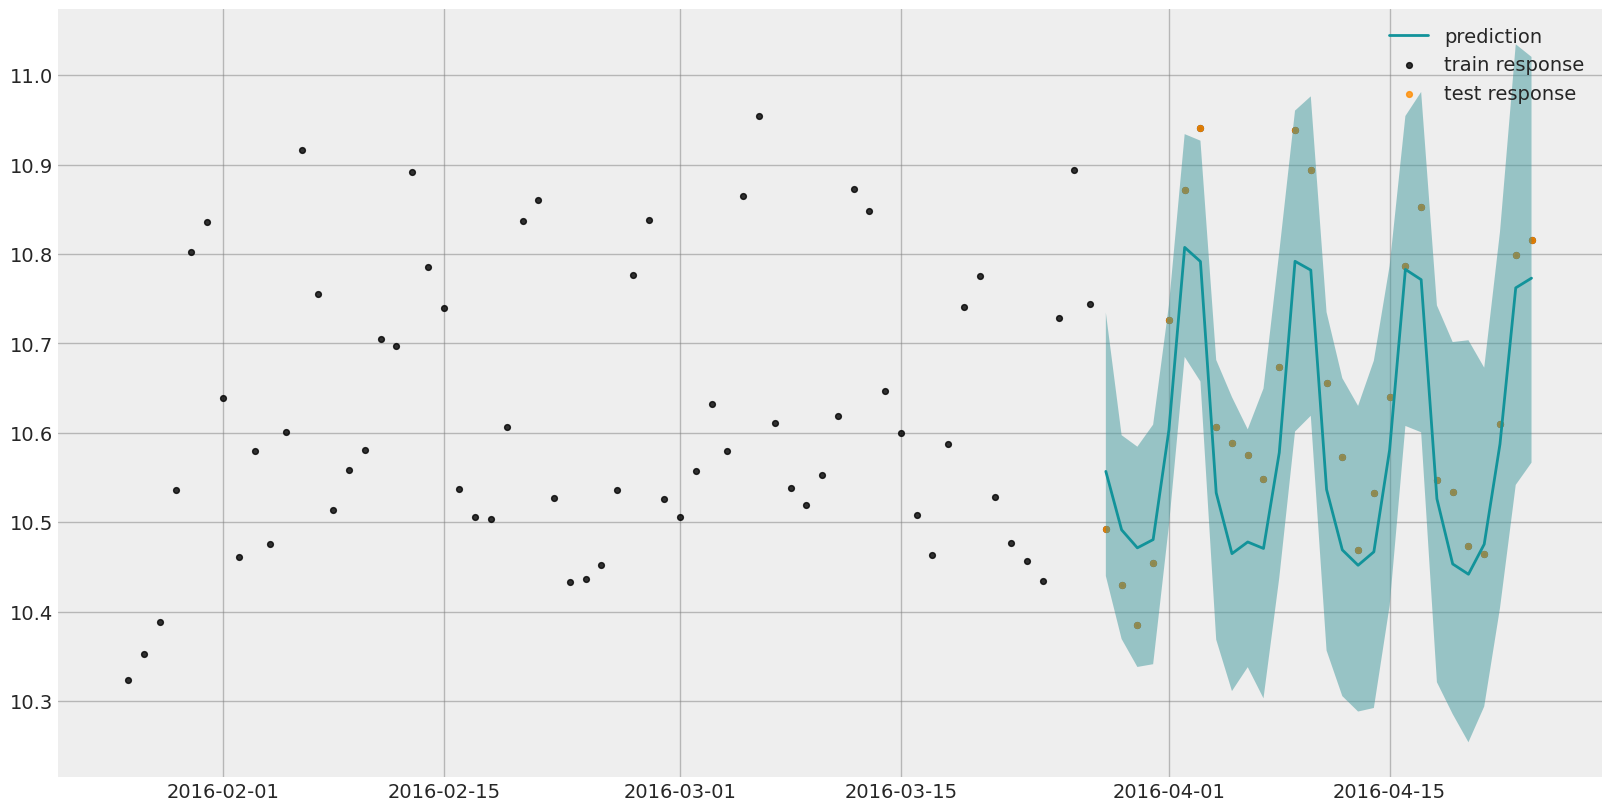

In [7]:
_ = plot_predicted_data(training_actual_df=df[-90:],
                        predicted_df=predicted_df[-90:],
                        test_actual_df=test_df,
                        date_col='date',
                        actual_col='sales')